**Author:** Jhosimar George Arias Figueroa

Implementation of Lenet-5 tested on small version of CIFAR-10

In [1]:
require "nn"
require "nngraph"
require "optim"

### Loading CIFAR-10 small dataset

In [2]:
-- Thanks to https://github.com/soumith/cvpr2015/blob/master/Deep%20Learning%20with%20Torch.ipynb
require 'paths'
if (not paths.filep("cifar10torchsmall.zip")) then
    os.execute('wget -c https://s3.amazonaws.com/torch7/data/cifar10torchsmall.zip')
    os.execute('unzip cifar10torchsmall.zip')
end
trainset = torch.load('cifar10-train.t7')
testset = torch.load('cifar10-test.t7')
classes = {'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [3]:
--train data does not have :size() method by default
function trainset:size()
    return self.data:size(1)
end

In [4]:
train_data = trainset.data:double()
train_label = trainset.label
test_data = testset.data:double()
test_label = testset.label
print("Train set size: ".. train_data:size(1) .. ", Test set size: " .. test_data:size(1))

Train set size: 10000, Test set size: 10000	


### Data Visualization

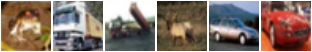

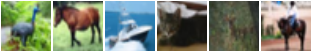

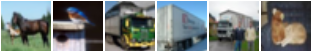

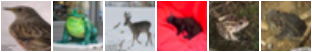

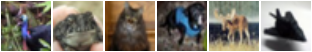

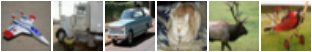

In [5]:
scale = 50
for i=1,36,6 do
    image_table = {}
    for j = 1,6 do
        image_table[j] = image.scale(train_data[i+j-1],scale)
    end
    itorch.image(image_table)
end

### Data Preparation

In [6]:
-- z-score normalization
-- mean and std are obtained from training data
mean = {}
std = {}
for i = 1,trainset.data:size(2) do
    mean[i] = train_data[{{},{i},{},{}}]:mean()      --mean estimation
    print('Channel ' .. i .. ', Mean: ' .. mean[i])
    train_data[{{},{i},{},{}}]:add( -mean[i] )       

    std[i] = train_data[{{},{i},{},{}}]:std()        --std estimation
    print('Channel ' .. i .. ', Mean: ' .. std[i])
    train_data[{{},{i},{},{}}]:div( std[i] )    
end

Channel 1, Mean: 125.83175029297	


Channel 1, Mean: 63.143400842609	


Channel 2, Mean: 123.26066621094	


Channel 2, Mean: 62.369209019002	


Channel 3, Mean: 114.03068681641	


Channel 3, Mean: 66.965808411114	


In [7]:
-- test normalization based on mean and std previously obtained
for i=1,3 do
    test_data[{{},{i},{},{}}]:add(-mean[i]):div(std[i])
end

### LeNet

In [8]:
do
    local Lenet = torch.class("LeNet")
    local lenet_model
    local criterion
    
    -- LeNet initialization
    function Lenet:__init()
        criterion = nn.ClassNLLCriterion() -- Log-likelihood classification loss
    end
    
    -- Build a LeNet from data X ( num_samples, num_channels, height, width ) and labels y 
    function Lenet:fit(X,y)
        self.data = X
        self.label = y
        self.num_samples = X:size(1)
        self.nChannels = X:size(2)
        self.height = X:size(3)
        self.width = X:size(4)
        lenet_model = create_lenet(self.nChannels, self.height, self.width)
    end
    
    -- LeNet architecture based on http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
    -- params: number of channels, height and width
    -- input: data (num_samples, num_channels, height, width)
    -- output: log probabilities for each class
    function create_lenet(nChannels, height, width)
        input = - nn.Identity()
        view = input - nn.View(-1, nChannels, height, width)
        conv1 = view - nn.SpatialConvolution(nChannels, 6, 5, 5)  -- 1 input channel, 6 output channels, 5x5 convolution kernel
        conv1 = conv1 - nn.ReLU()                          -- non-linearity 
        pool1 = conv1 - nn.SpatialMaxPooling(2, 2, 2, 2)   -- 2x2 max pooling, stride 2 in width and height
        conv2 = pool1 - nn.SpatialConvolution(6, 16, 4, 4) -- 6 input channels, 16 output channels, 4x4 convolution kernel
        conv2 = conv2 - nn.ReLU()                          -- non-linearity
        pool2 = conv2 - nn.SpatialMaxPooling(2, 2, 2, 2)   -- 2x2 max pooling, stride 2 in width and height
        resize = pool2 - nn.View(16 * 5 * 5)               -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
        fc1 = resize - nn.Linear(16 * 5 * 5, 120 )         -- fully connected layer fc1
        fc1 = fc1 - nn.ReLU()                              -- non-linearity
        fc2 = fc1 - nn.Linear(120 , 84 )                   -- fully connected layer fc1
        fc2 = fc2 - nn.ReLU()                              -- non-linearity
        fc3 = fc2 - nn.Linear( 84 , 10 )                   -- 10 is the number of outputs of the network (in this case, 10 digits)
        output = fc3 - nn.LogSoftMax()                     -- converts the output to a log-probability. Useful for classification problems
        return nn.gModule({input}, {output})               
    end
    
    --Function used in optim module for optimization
    --Return loss obtained after forward and gradients after backward
    function feval()
        lenet_model:zeroGradParameters()
        
        -- forward
        prediction = lenet_model:forward(batch_data)
        loss = criterion:forward(prediction, batch_label)
        
        -- backward
        gradients = criterion:backward(prediction, batch_label)
        lenet_model:backward(batch_data, gradients)
        
        return loss, gradParams
    end

    -- Train LeNet
    function Lenet:train(batch_size, epochs, learning_rate, optimiser)
        params, gradParams = lenet_model:getParameters()
        for epoch = 1,epochs do
            local indices_all = torch.randperm(self.num_samples):long()
            local indices = indices_all:split(batch_size)
            local Loss = 0.0
            -- Training in batches
            for t,v in ipairs(indices) do
                xlua.progress(t, #indices)
                batch_label = self.label:index(1,v)
                batch_data = self.data:index(1, v)
                __, loss = optim[optimiser](feval, params, {learningRate = learning_rate })
                Loss = Loss + loss[1]
            end
            print("Epoch: " .. epoch .. " Loss: " .. Loss/batch_size )
        end
    end    
    
    -- Test LeNet
    function Lenet:test(test_data, test_label)
        print("Starting Tests...")
        correct = 0
        for i=1,test_data:size(1) do
            if i % 1000 == 0 then
                print("Tested " .. i .. " elements")
            end
            local groundtruth = test_label[i]
            local prediction = lenet_model:forward(test_data[i])
            local confidences, indices = torch.sort(prediction, true)
            if groundtruth == indices[1] then
                correct = correct + 1
            end
        end
        print("Accuracy: " .. 100*correct/test_data:size(1) .. ' % ')
    end
    
end

In [9]:
-- LeNet Instantiation
lenet = LeNet()

-- Use CIFAR-10 dataset
lenet:fit(train_data, train_label)

-- Train LeNet (batch_size, epochs, learning_rate, optimizer)
lenet:train(100, 30, 0.001, "adam")

 [=====================================================================================>]                                Tot: 8s951ms | Step: 91ms 

Epoch: 1 Loss: 2.0580962008176	


 [=====================================================================================>]                                Tot: 8s975ms | Step: 92ms 

Epoch: 2 Loss: 1.8812596079215	


 [=====================================================================================>]                                Tot: 11s953ms | Step: 123ms 

Epoch: 3 Loss: 1.7725462133725	


 [=====================================================================================>]                                Tot: 10s115ms | Step: 104ms 

Epoch: 4 Loss: 1.7122853095685	


 [=====================================================================================>]                                Tot: 8s816ms | Step: 90ms 

Epoch: 5 Loss: 1.6676150118311	


 [=====================================================================================>]                                Tot: 8s741ms | Step: 90ms 

Epoch: 6 Loss: 1.6045302114197	


 [=====================================================================================>]                                Tot: 10s234ms | Step: 105ms 

Epoch: 7 Loss: 1.552883658723	


 [=====================================================================================>]                                Tot: 11s512ms | Step: 118ms 

Epoch: 8 Loss: 1.5140714806795	


 [=====================================================================================>]                                Tot: 8s781ms | Step: 90ms 

Epoch: 9 Loss: 1.4655696800274	


 [=====================================================================================>]                                Tot: 8s792ms | Step: 90ms 

Epoch: 10 Loss: 1.4341654420693	


 [=====================================================================================>]                                Tot: 8s702ms | Step: 89ms 

Epoch: 11 Loss: 1.3856704174688	


 [=====================================================================================>]                                Tot: 8s805ms | Step: 90ms 

Epoch: 12 Loss: 1.3540639324811	


 [=====================================================================================>]                                Tot: 9s157ms | Step: 94ms 

Epoch: 13 Loss: 1.322523512043	


 [=====================================================================================>]                                Tot: 8s734ms | Step: 90ms 

Epoch: 14 Loss: 1.2905353599861	


 [=====================================================================================>]                                Tot: 8s696ms | Step: 89ms 

Epoch: 15 Loss: 1.2550295618956	


 [=====================================================================================>]                                Tot: 8s946ms | Step: 92ms 

Epoch: 16 Loss: 1.2399542906092	


 [=====================================================================================>]                                Tot: 8s818ms | Step: 90ms 

Epoch: 17 Loss: 1.216042274432	


 [=====================================================================================>]                                Tot: 8s863ms | Step: 91ms 

Epoch: 18 Loss: 1.180772771969	


 [=====================================================================================>]                                Tot: 8s842ms | Step: 91ms 

Epoch: 19 Loss: 1.1631386562617	


 [=====================================================================================>]                                Tot: 8s745ms | Step: 90ms 

Epoch: 20 Loss: 1.1249831385033	


 [=====================================================================================>]                                Tot: 8s799ms | Step: 90ms 

Epoch: 21 Loss: 1.098168714968	


 [=====================================================================================>]                                Tot: 8s750ms | Step: 90ms 

Epoch: 22 Loss: 1.0743991664782	


 [=====================================================================================>]                                Tot: 9s174ms | Step: 94ms 

Epoch: 23 Loss: 1.0560127870573	


 [=====================================================================================>]                                Tot: 9s196ms | Step: 94ms 

Epoch: 24 Loss: 1.0259022425474	


 [=====================================================================================>]                                Tot: 9s35ms | Step: 93ms 

Epoch: 25 Loss: 1.000303018304	


 [=====================================================================================>]                                Tot: 8s826ms | Step: 90ms 

Epoch: 26 Loss: 0.96845936241171	


 [=====================================================================================>]                                Tot: 8s903ms | Step: 91ms 

Epoch: 27 Loss: 0.94822450346033	


 [=====================================================================================>]                                Tot: 8s716ms | Step: 89ms 

Epoch: 28 Loss: 0.91921926360874	


 [=====================================================================================>]                                Tot: 8s759ms | Step: 90ms 

Epoch: 29 Loss: 0.89414209071515	


 [=====================================================================================>]                                Tot: 8s879ms | Step: 91ms 

Epoch: 30 Loss: 0.87170535115103	


In [10]:
lenet:test(test_data, test_label)

Starting Tests...	


Tested 1000 elements	


Tested 2000 elements	


Tested 3000 elements	


Tested 4000 elements	


Tested 5000 elements	


Tested 6000 elements	


Tested 7000 elements	


Tested 8000 elements	


Tested 9000 elements	


Tested 10000 elements	


Accuracy: 52.22 % 	

